# LAMP
Prepare dataframes of each group before

In [1]:
# Modules
import os
import time
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager
import dateutil
from dateutil.relativedelta import relativedelta

print("pandas",pd.__version__)
print("numpy",np.__version__)
print("matplotlib",mpl.__version__)
print("dateutil",dateutil.__version__)

# Set a font style
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["font.size"] = 15

# Make an editable PDF 
mpl.rcParams["pdf.fonttype"] = 42 
mpl.rcParams['ps.fonttype'] = 42 

pandas 1.3.4
numpy 1.22.4
matplotlib 3.6.3
dateutil 2.8.2


In [2]:
# Data
current_path = "/Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/"
csv_dir = current_path + 'NephroticSyndrome_csv/'
output_dir = current_path +'NephroticSyndrome_LAMP/'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

df_p = pd.read_csv(csv_dir+'patient/Group_diseases.csv')
df_c = pd.read_csv(csv_dir+'control/Group_diseases.csv')

### LAMP function

In [3]:
def LAMP(
    df_case:pd.DataFrame(),
    df_control,
    dict_periods,
    output_csv_dir,
    index = 'Enrollee ID',
    column = 'ICD10_3_Code',
    target = 'Target',
    time = 'Target_diag_yyyymm', 
    time_from = 'Months_from_target_diag',
    start = 'Observation_start_yyyymm', 
    end = 'Observation_end_yyyymm',
    frmt = "%Y%m"
)-> None:
    
    
    
    """
    LAMP
    This function uses functions below, and finally change output csv file for LAMP analysis
    """  
    # Combine data
    df_o = pd.concat([df_case,df_control])
    df_period = LAMP_period(df_o, index, time, start, end, frmt, dict_periods)
    for period,term in dict_periods.items():
        # Extract data whitin the time interval of interest
        df_temp = df_o[((term[0] <= df_o[time_from])&(df_o[time_from] < term[1]))]
        # Make dataframe for LAMP
        df_lamp_r = LAMP_processing(df_temp,index,column, period, df_period)
        # 
        df_n = LAMP_target(df_case,df_control,df_period,target, index,period)
        df_lamp_r.reset_index().rename(columns = {"index":"#gene"}).sort_values("#gene").to_csv(output_csv_dir+ f"{period}.csv", index=False)
        df_n.reset_index().rename(columns = {index:"#gene"}).sort_values("#gene").to_csv(output_csv_dir + f"{period}_n.csv", index=False)
 



def LAMP_period(df_o:pd.DataFrame(), 
                index:str, 
                time:str, 
                start:str, 
                end:str, frmt, dict_periods
               )-> pd.DataFrame():
    
    
    
    """
    LAMP_period()
        This function checks 
         input
           index: ID column name
           time: Target date column name
           start: Start date column name
           end: End date column name
           frmt: Date format = "%Y%m" 
           kwargs: Dictionary of periods
    """
    
    df = df_o.copy().drop_duplicates(index)
    df["start"] = (pd.to_datetime(df[start],format=frmt).dt.to_period('M').view('int')
                         - pd.to_datetime(df[time],format=frmt).dt.to_period('M').view('int'))
    df["end"] = (pd.to_datetime(df[end],format=frmt).dt.to_period('M').view('int')
                     - pd.to_datetime(df[time],format=frmt).dt.to_period('M').view('int'))
    for period,term in dict_periods.items():
        # People observed throughout the time interval
        df.loc[df["start"] <= term[0], period] = 1 
        
    return df.fillna(0)
    
    
    
    
    
def LAMP_processing(df:pd.DataFrame(), 
                    index:str,
                    column:str,
                    period,
                    df_period:pd.DataFrame()
                   )-> pd.DataFrame():
    
    
    
    
    """
    LAMP_processing()
        Making LAMP dataframe by counting the number of diagnoses
        Input
           df: Data
           index: ID column name
           column: Column name to count 
           period: Dict.keys for periods
        Output
           return dataframe for LAMP
    """
    # List for counting
    df_lamp = df.groupby(index)[column].unique().reset_index()
    df_lamp.index = df_lamp[index]
    df_lamp = df_lamp.iloc[:,1:]
    
    # List of diseases 
    codes = list(set(df[column]))
    df_lamp_r = pd.DataFrame()
    
    # Based on each ID
    for ID in df_period[(df_period[period] == 1)][index]:
        for code in codes:
            # Set 0 onto disease on which no person is diagnosed 
            df_lamp_r.at[ID, code] = np.where((code in df_lamp.at[ID, column]), "1", "0") if (ID in df_lamp.index) else "0"
    return df_lamp_r




def LAMP_target(df_case:pd.DataFrame,
                df_control:pd.DataFrame,
                df_period:pd.DataFrame,
                target: str,
                index: str,
                period
               )->pd.DataFrame:
    
    
    
    """
    LAMP_target
        This function make a dataframe that includes result variables for LAMP analysis
        Input
            df_case: Case data
            df_control:Control data
            df_period: Made by another function here
            target: column name for group division
            index: ID column name
            period: Period keys from dictionary
        Output
            Second dataframe for LAMP analysis
    """
    df_ptemp =df_case.drop_duplicates(index)
    df_ctemp =df_control.drop_duplicates(index)
    df_ptemp.loc[:,target] = 1
    df_ctemp.loc[:,target] = 0
    df_neph = pd.concat([df_ptemp, df_ctemp], join = "inner")[[index, target]].reset_index(drop = True)      
    
    # Data frame for target variables
    df_n = pd.merge(df_period[(df_period[period] == 1)][index], df_neph, how = "left", 
                    left_on = index, right_on = index)
    df_n.index = df_n.iloc[:,0]
    df_n = df_n.iloc[:,1:]
    return df_n

### Creating csv files for LAMP

In [4]:
# Define time frame
dict_periods = {
    '-60m':[-66,-54],
    '-54m':[-60,-48],
    '-48m':[-54,-42],
    '-42m':[-48,-36],
    '-36m':[-42,-30],
    '-30m':[-36,-24],
    '-24m':[-30,-18],
    '-18m':[-24,-12],
    '-12m':[-18,-6],
    '-06m':[-12,0],
    }

# Output path
LAMP(df_p,
     df_c,
     dict_periods,
     output_csv_dir = output_dir,
     column = 'ICD10_3_Code')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [5]:
# In your command line 
# Here, define proper path that includes LAMP package (https://a-terada.github.io/lamp/)

# For example
#!python ./lamp/lamp.py -p fisher ./NephroticSyndrome_LAMP/-60m.csv ./NephroticSyndrome_LAMP/-60m_n.csv 0.05 > ./NephroticSyndrome_LAMP/-60m_result.txt

!python /Users/chidakatsuyuki/Desktop/Project/temp/lamp/lamp.py -p fisher /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-60m.csv /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-60m_n.csv 0.05 > /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-60m_result.txt 
!python /Users/chidakatsuyuki/Desktop/Project/temp/lamp/lamp.py -p fisher /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-54m.csv /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-54m_n.csv 0.05 > /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-54m_result.txt 
!python /Users/chidakatsuyuki/Desktop/Project/temp/lamp/lamp.py -p fisher /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-48m.csv /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-48m_n.csv 0.05 > /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-48m_result.txt 
!python /Users/chidakatsuyuki/Desktop/Project/temp/lamp/lamp.py -p fisher /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-42m.csv /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-42m_n.csv 0.05 > /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-42m_result.txt 
!python /Users/chidakatsuyuki/Desktop/Project/temp/lamp/lamp.py -p fisher /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-36m.csv /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-36m_n.csv 0.05 > /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-36m_result.txt 
!python /Users/chidakatsuyuki/Desktop/Project/temp/lamp/lamp.py -p fisher /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-30m.csv /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-30m_n.csv 0.05 > /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-30m_result.txt 
!python /Users/chidakatsuyuki/Desktop/Project/temp/lamp/lamp.py -p fisher /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-24m.csv /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-24m_n.csv 0.05 > /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-24m_result.txt 
!python /Users/chidakatsuyuki/Desktop/Project/temp/lamp/lamp.py -p fisher /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-18m.csv /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-18m_n.csv 0.05 > /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-18m_result.txt 
!python /Users/chidakatsuyuki/Desktop/Project/temp/lamp/lamp.py -p fisher /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-12m.csv /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-12m_n.csv 0.05 > /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-12m_result.txt 
!python /Users/chidakatsuyuki/Desktop/Project/temp/lamp/lamp.py -p fisher /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-06m.csv /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-06m_n.csv 0.05 > /Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/NephroticSyndrome_LAMP/-06m_result.txt 


Read input files ...
Compute the optimal correction factor ... 104
Compute P-values of testable combinations ...
Output results ...
Read input files ...
Compute the optimal correction factor ... 148
Compute P-values of testable combinations ...
Output results ...
Read input files ...
Compute the optimal correction factor ... 196
Compute P-values of testable combinations ...
Output results ...
Read input files ...
Compute the optimal correction factor ... 247
Compute P-values of testable combinations ...
Output results ...
Read input files ...
Compute the optimal correction factor ... 297
Compute P-values of testable combinations ...
Output results ...
Read input files ...
Compute the optimal correction factor ... 350
Compute P-values of testable combinations ...
Output results ...
Read input files ...
Compute the optimal correction factor ... 437
Compute P-values of testable combinations ...
Output results ...
Read input files ...
Compute the optimal correction factor ... 480
Compute P

In [6]:
df = {}  
result_suffix = "_result.txt"

df_period = LAMP_period(pd.concat([df_p, df_c]), 'Enrollee ID', 'Target_diag_yyyymm', 'Observation_start_yyyymm',
                        'Observation_end_yyyymm', "%Y%m",dict_periods)
df_people = df_period.drop_duplicates('Enrollee ID').groupby('Target')[list(dict_periods.keys())].agg(sum).T.rename(columns = {0:'Target-',1:'Target+'})

for period in dict_periods:
    # Count people for odds calculation
    case = df_people.loc[period, "Target+"]
    control  = df_people.loc[period, "Target-"] 
    # Read LAMP result
    df[period] = pd.read_table(output_dir + period +result_suffix, header = 8)
    if len(df[period]) >=1:
        # Remove "time" column
        df[period].drop(index = len(df[period])-1, axis = 0, inplace = True) 
        # Odds calculation
        df[period]["Odds"] = (df[period]["# of positives in the targets"]*(control - df[period]["# of target rows"]+ df[period]["# of positives in the targets"]))/((df[period]["# of target rows"]- df[period]["# of positives in the targets"])*(case-df[period]["# of positives in the targets"]))
        # Logarothmic transform of p-value
        df[period]["-log10_p"] = -np.log10(df[period]["Adjusted p-value"])  
        # Add list of code on the side of the table
        df[period]= pd.concat([df[period], df[period]['Combination'].str.split(',', expand = True)], axis = 1)

        # Save as excel file
with pd.ExcelWriter(output_dir+"LAMPsummary.xlsx") as writer:
    df_people.to_excel(writer, sheet_name="Number_of_ID", encoding = "cp932")
    for period in dict_periods:
        df[period].to_excel(writer, sheet_name = period, encoding = "cp932")

## LAMP_tnet

In [7]:
# ICD10 codes in English
# Dawnloaded from URL: https://www.health.gov.za/icd-10-master-industry-table/
df_cdref_ = pd.read_excel("/Users/chidakatsuyuki/Desktop/Project/sample/ICD-10_MIT_2021_Excel_16-March_2021.xlsx", 
                          sheet_name = "SA ICD-10 MIT 2021")
df_cdref_e = df_cdref_[["ICD10_3_Code", "ICD10_3_Code_Desc"]].drop_duplicates()
df_cdref_e.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,ICD10_3_Code,ICD10_3_Code_Desc
0,A00,Cholera
4,A01,Typhoid and paratyphoid fevers
10,A02,Other salmonella infections
16,A03,Shigellosis
23,A04,Other bacterial intestinal infections


In [8]:
from teneto import TemporalNetwork
import pandas as pd
import numpy as np

df ={}
for period in dict_periods:
    df[period]= pd.read_excel(output_dir +"LAMPsummary.xlsx", sheet_name=period, index_col=0)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [9]:
df[period].head()

,Rank,Raw p-value,Adjusted p-value,Combination,Arity,# of target rows,# of positives in the targets,Odds,-log10_p,0,1,2
0,1,3.037000e-15,2.262600e-12,I10,1,185,138,4.139735,11.645392,I10,NaN,NaN
1,2,5.794600e-12,4.317000e-09,R80,1,36,36,inf,8.364818,R80,NaN,NaN
2,3,5.399400e-11,4.022600e-08,N02,1,33,33,inf,7.395493,N02,NaN,NaN
3,4,7.856200e-11,5.852900e-08,"I10,E78",2,117,90,4.111111,7.232629,I10,E78,NaN
4,5,2.371800e-10,1.767000e-07,"N03,I10",2,31,31,inf,6.752763,N03,I10,NaN


In [10]:
code_set=set()
for period in dict_periods:
    df_temp = df[period][df[period]["Arity"] < 3]
    if 1 in df_temp.columns:
        code_set = set(df_temp[0])|set(df_temp[1])|code_set
    else:
        code_set = set(df_temp[0])|code_set
        
df_tnet_code = pd.DataFrame(data = {"code":list(code_set)})
df_tnet_code = pd.merge(df_tnet_code, df_cdref_e, how ="inner", left_on = "code", right_on ="ICD10_3_Code")
df_tnet_code.drop("code", axis = 1, inplace = True)
df_tnet_code = df_tnet_code.sort_values("ICD10_3_Code").reset_index()
df_tnet_code.head()

,index,ICD10_3_Code,ICD10_3_Code_Desc
0,13,E11,Type 2 diabetes mellitus
1,1,E14,Unspecified diabetes mellitus
2,15,E78,Disorders of lipoprotein metabolism and other ...
3,3,E79,Disorders of purine and pyrimidine metabolism
4,14,H52,Disorders of refraction and accommodation


In [11]:
# For temporal network
df_temp1 = {}

for period in dict_periods:
    if len(df[period]) > 0:
        if len(df[period][df[period]["Arity"] == 2])>0: # Skip when there is no combination which is significant different
            df_temp1[period] = df[period][df[period]['Arity'] == 2]
            df_temp1[period] = df_temp1[period][["-log10_p", 0, 1]] # We omitted tiad or more diseases combination
            df_temp1[period].rename({0:"i", 1:"j", "-log10_p": "weight"}, axis = 1, inplace = True)


df_tnet  = []
for period in dict_periods:
    if len(df[period]) > 0:
        if len(df[period][df[period]["Arity"] == 2])>0: # Skip when there is no combination which is significant different
            df_temp = df_temp1[period]
            df_temp["t"] = period 
            df_tnet.append(df_temp)
df_tnet = pd.concat(df_tnet)

# Label each node 
l = list(df_tnet_code["ICD10_3_Code"])
# Change characters of time interval into number
m = list(dict_periods.keys())


df_tnet[["i", "j", "t"]] = df_tnet.agg({"i":(lambda x: l.index(x)), 
                                    "j":(lambda x: l.index(x)),
                                    "t":(lambda x: m.index(x))})
df_tnet.max()


weight     7.232629
i         21.000000
j         21.000000
t          9.000000
dtype: float64

In [12]:
# Set y-axis as ICD10 descriptions with their codes
df_tnet_code["yaxis"] = df_tnet_code["ICD10_3_Code_Desc"] + ": " + df_tnet_code["ICD10_3_Code"]
df_tnet_code["yaxis"]

0                         Type 2 diabetes mellitus: E11
1                    Unspecified diabetes mellitus: E14
2     Disorders of lipoprotein metabolism and other ...
3     Disorders of purine and pyrimidine metabolism:...
4        Disorders of refraction and accommodation: H52
5                 Essential (primary) hypertension: I10
6     Acute upper respiratory infections of multiple...
7                                 Acute bronchitis: J20
8                  Vasomotor and allergic rhinitis: J30
9         Chronic diseases of tonsils and adenoids: J35
10                                          Asthma: J45
11               Gastro-oesophageal reflux disease: K21
12                                   Gastric ulcer: K25
13                        Gastritis and duodenitis: K29
14                         Other diseases of liver: K76
15                                Other dermatitis: L30
16             Recurrent and persistent haematuria: N02
17                      Chronic nephritic syndro

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/teneto/utils/utils.py:947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ij'] = list(map(lambda x: tuple(sorted(x)), list(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

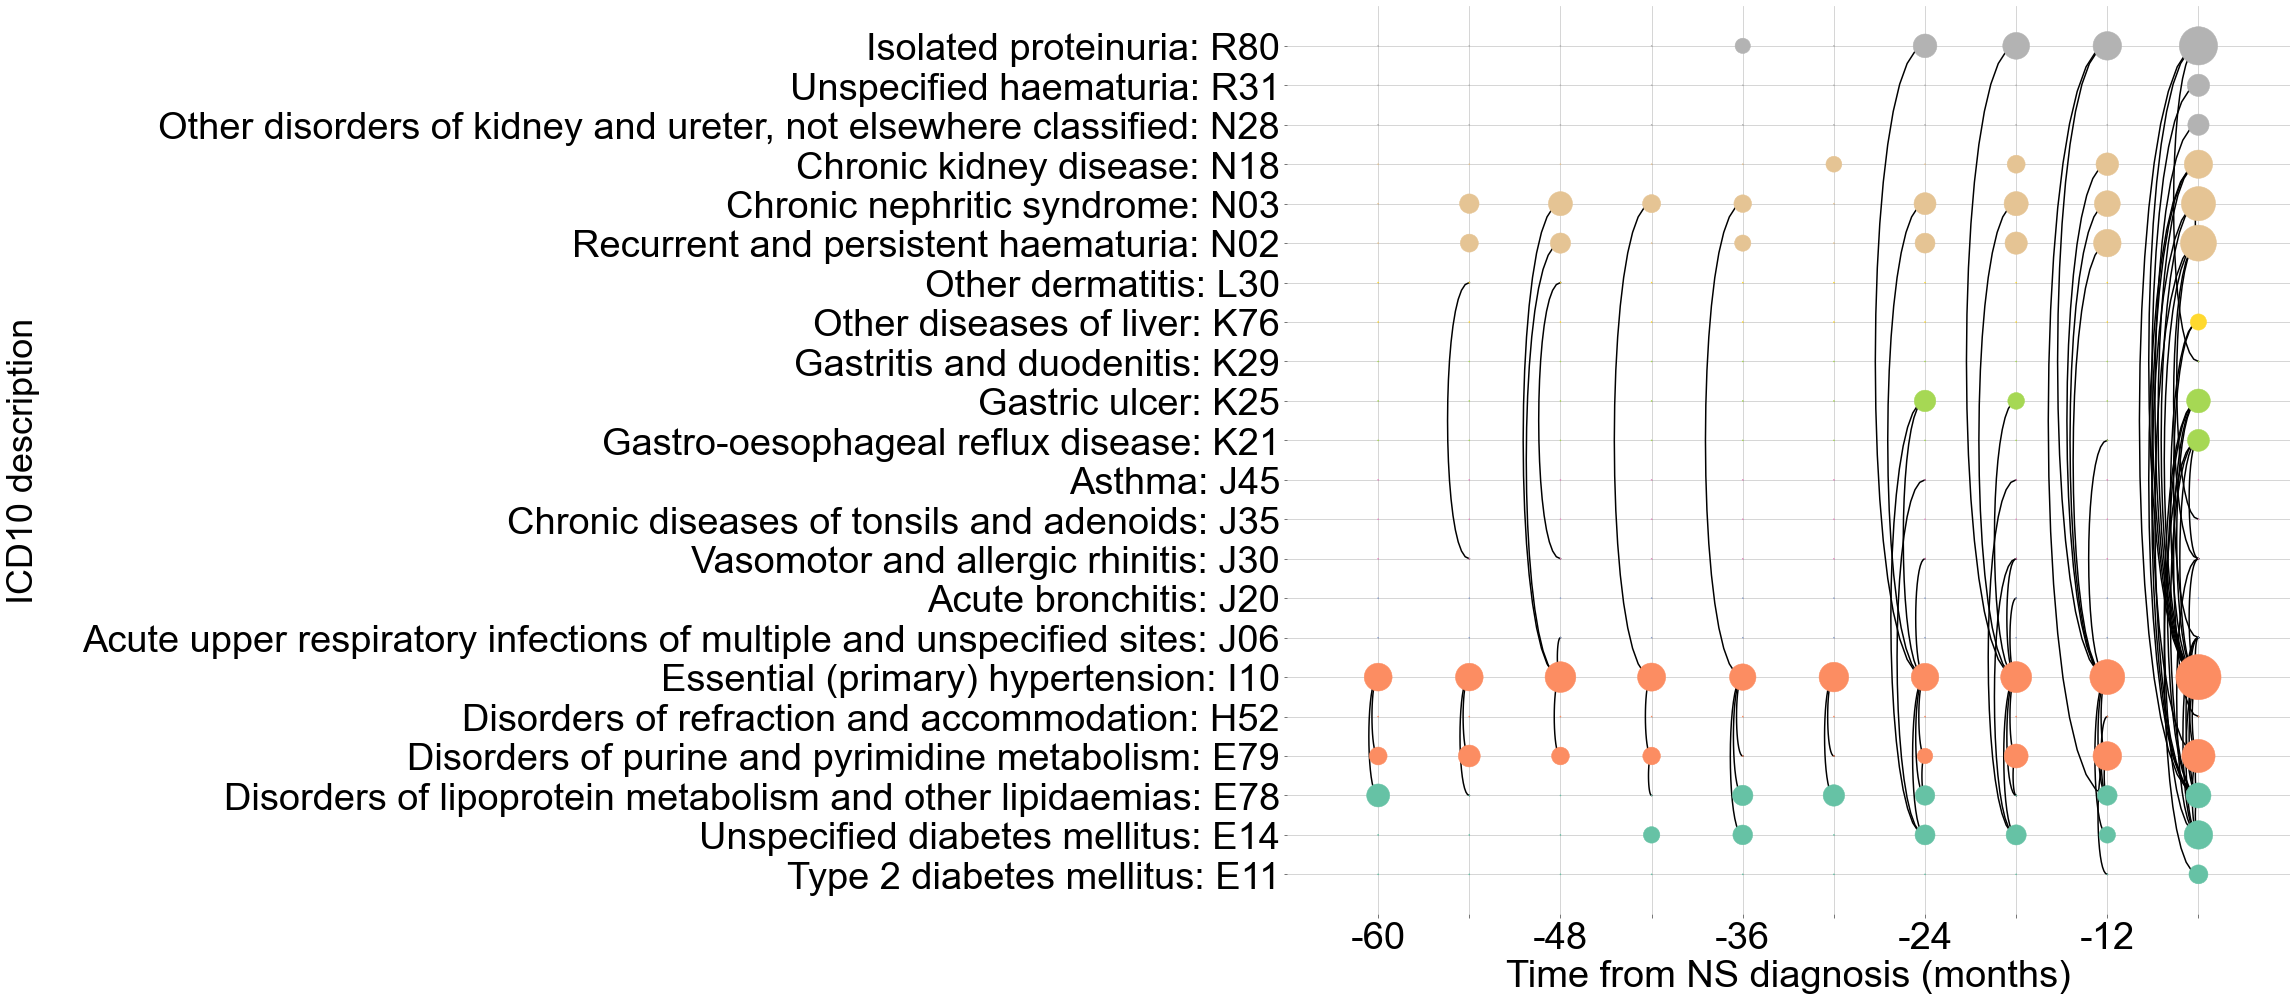

In [44]:

from teneto import TemporalNetwork

# These dataframes were used like a placeholder to draw empty columns
# Please change the length depending on the number of intervals
df_dum = pd.DataFrame(columns = df_tnet.columns, 
                      data = [[0,0,0,0], [0,0,0,1], [0,0,0,2], [0,0,0,3],
                            [0,0,0,4], [0,0,0,5], [0,0,0,6],
                            [0,0,0,7], [0,0,0,8], [0,0,0,9]])
df_periods = pd.DataFrame(data = {"period":m})
tunit = 'years'
df_tnet = pd.concat([df_tnet, df_dum])
tnet = TemporalNetwork(from_df = df_tnet,  
                       nodelabels= list(df_tnet_code["ICD10_3_Code_Desc"]), 
                       timelabels = ["-5.0", "-4.5", "-4.0", "-3.5", "-3.0", "-2.5", "-2.0", "-1.5", "-1.0", "-0.5"],
                       nettype='wu')

# Add weight on edges
tnet.network = df_tnet[["i", "j", "t", "weight"]] 
tnet._update_network()

# Add weight on nodes
df_netnode = pd.DataFrame(data = {"ICD10_3_Code":l, "name": df_tnet_code["ICD10_3_Code_Desc"]})


i = 0
keys = list(dict_periods.keys())



for period in dict_periods:
    df_temp2 = pd.DataFrame()
    
    # With a significant node or edge
    if len(df[period]) > 0:
        # With a significant node
        if len(df[period][df[period]["Arity"] == 1])>0:
            df_temp2 = df[period][df[period]['Arity'] == 1].loc[:,[0, "-log10_p"]]
            df_temp2.columns = ["0", "-log10_p"+period]
            df_netnode = pd.merge(df_netnode, df_temp2, how ="left", left_on ="ICD10_3_Code", 
                                  right_on ="0", validate = "one_to_one" 
                                       ).drop("0", axis = 1)
        else:
            df_temp2 = pd.DataFrame(data = {"code":l, "dummy": np.zeros(len(l))})
            df_temp2.columns = ["0", "-log10_p"+period]
            df_netnode = pd.merge(df_netnode, df_temp2, how ="left", left_on ="ICD10_3_Code", 
                                  right_on ="0", validate = "one_to_one"
                                       ).drop("0", axis = 1)
    
    # If there are no nodes with significant differences, a column is created.
    else:
            df_temp2 = pd.DataFrame(data = {"code":l, "dummy": np.zeros(len(l))})
            df_temp2.columns = ["0", "-log10_p"+period]
            df_netnode = pd.merge(df_netnode, df_temp2, how ="left", left_on = "ICD10_3_Code", 
                                  right_on ="0", validate = "one_to_one" 
                                       ).drop("0", axis = 1)
    i += 1
    
# Set node size based on weight
nodesize = df_netnode.fillna(0).iloc[:,2:].T.to_numpy() 




fig, ax = plt.subplots(figsize = (32,14))
fsize = [38,36] # Font sizes


# Set margins so that labels are not overlooked
plt.subplots_adjust(left = 0.2)

# Draw temporal network
tnet.plot('slice_plot', cmap='Set2', ax = ax, 
          plotedgeweights = False, # Use edge size
          edgeweightscalar = 2.6, # Width of base edge size
          nodesize = nodesize*175 + 1) # Change node size
# Label names on axis
ax.set_ylabel("ICD10 description\n",size=fsize[1],c="k")
ax.set_xlabel("Time from NS diagnosis (months)",size=fsize[0],c="k")
ax.set_yticklabels(list(df_tnet_code["yaxis"]), size=fsize[0], color = "k")
ax.set_xticklabels(["-60", "", "-48", "", "-36", "", "-24", "", "-12", ""],size=fsize[0], color = "k")
plt.tight_layout()

# Layout of this graph
plt.gca().grid("white")
mpl.style.use('ggplot')
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams['grid.color'] = "black"
mpl.rcParams['grid.alpha'] = 0.2
mpl.rcParams['savefig.edgecolor']= '#ffffff'
mpl.rcParams['savefig.facecolor']= '#ffffff'


plt.savefig(output_dir+"teneto.pdf")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/teneto/utils/utils.py:947: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ij'] = list(map(lambda x: tuple(sorted(x)), list(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

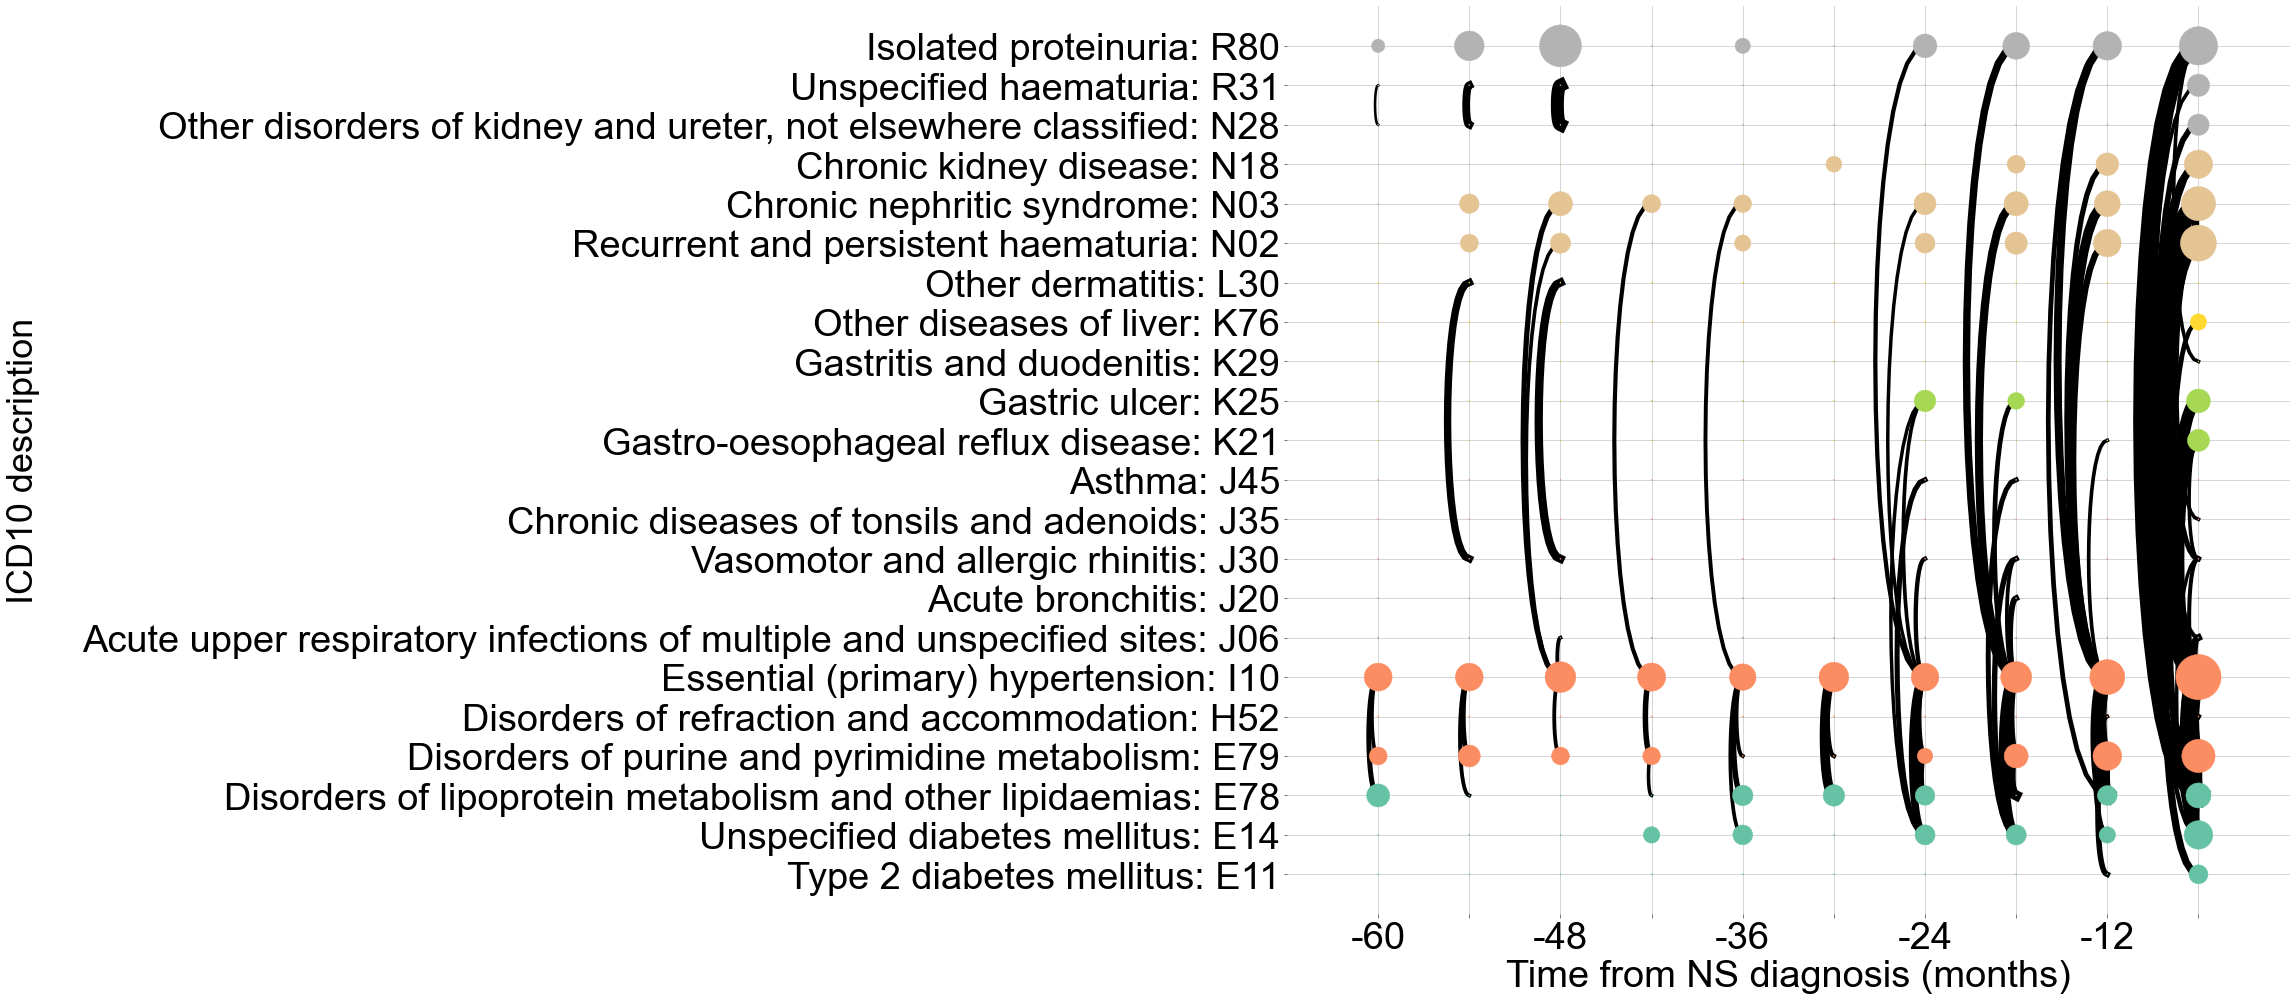

In [42]:

from teneto import TemporalNetwork

# These dataframes were used like a placeholder to draw empty columns
# Please change the length depending on the number of intervals
df_dum = pd.DataFrame(columns = df_tnet.columns, 
                      data = [[0,0,0,0], [0,0,0,1], [0,0,0,2], [0,0,0,3],
                            [0,0,0,4], [0,0,0,5], [0,0,0,6],
                            [0,0,0,7], [0,0,0,8], [0,0,0,9]])
df_periods = pd.DataFrame(data = {"period":m})
tunit = 'years'
df_tnet = pd.concat([df_tnet, df_dum])
tnet = TemporalNetwork(from_df = df_tnet,  
                       nodelabels= list(df_tnet_code["ICD10_3_Code_Desc"]), 
                       timelabels = ["-5.0", "-4.5", "-4.0", "-3.5", "-3.0", "-2.5", "-2.0", "-1.5", "-1.0", "-0.5"],
                       nettype='wu')

# Add weight on edges
tnet.network = df_tnet[["i", "j", "t", "weight"]] 
tnet._update_network()

# Add weight on nodes
df_netnode = pd.DataFrame(data = {"ICD10_3_Code":l, "name": df_tnet_code["ICD10_3_Code_Desc"]})


i = 0
keys = list(dict_periods.keys())



for period in dict_periods:
    df_temp2 = pd.DataFrame()
    
    # With a significant node or edge
    if len(df[period]) > 0:
        # With a significant node
        if len(df[period][df[period]["Arity"] == 1])>0:
            df_temp2 = df[period][df[period]['Arity'] == 1].loc[:,[0, "-log10_p"]]
            df_temp2.columns = ["0", "-log10_p"+period]
            df_netnode = pd.merge(df_netnode, df_temp2, how ="left", left_on ="ICD10_3_Code", 
                                  right_on ="0", validate = "one_to_one" 
                                       ).drop("0", axis = 1)
        else:
            df_temp2 = pd.DataFrame(data = {"code":l, "dummy": np.zeros(len(l))})
            df_temp2.columns = ["0", "-log10_p"+period]
            df_netnode = pd.merge(df_netnode, df_temp2, how ="left", left_on ="ICD10_3_Code", 
                                  right_on ="0", validate = "one_to_one"
                                       ).drop("0", axis = 1)
    
    # If there are no nodes with significant differences, a column is created.
    else:
            df_temp2 = pd.DataFrame(data = {"code":l, "dummy": np.zeros(len(l))})
            df_temp2.columns = ["0", "-log10_p"+period]
            df_netnode = pd.merge(df_netnode, df_temp2, how ="left", left_on = "ICD10_3_Code", 
                                  right_on ="0", validate = "one_to_one" 
                                       ).drop("0", axis = 1)
    i += 1
    
# Set node size based on weight
nodesize = df_netnode.fillna(0).iloc[:,2:].T
nodesize.iloc[0,21] = 1
nodesize.iloc[1,21] = 5
nodesize.iloc[2,21] = 10
nodesize = nodesize.to_numpy() 

# Add weight on edges
edge = np.array([[19,20,0,1],[19,20,1,3],[19,20,2,5]])
edge = pd.DataFrame(edge,columns=["i", "j", "t", "weight"])

tnet.network = pd.concat(
    [df_tnet[["i", "j", "t", "weight"]],edge]
)
tnet._update_network()

fig, ax = plt.subplots(figsize = (32,14))
fsize = [38,36] # Font sizes


# Set margins so that labels are not overlooked
plt.subplots_adjust(left = 0.2)




# Draw temporal network
tnet.plot('slice_plot', cmap='Set2', ax = ax, 
          plotedgeweights = True, # Use edge size
          edgeweightscalar = 2.6, # Width of base edge size
          nodesize = nodesize*175 + 1) # Change node size
# Label names on axis
ax.set_ylabel("ICD10 description\n",size=fsize[1],c="k")
ax.set_xlabel("Time from NS diagnosis (months)",size=fsize[0],c="k")
ax.set_yticklabels(list(df_tnet_code["yaxis"]), size=fsize[0], color = "k")
ax.set_xticklabels(["-60", "", "-48", "", "-36", "", "-24", "", "-12", ""],size=fsize[0], color = "k")
plt.tight_layout()

# Layout of this graph
plt.gca().grid("white")
mpl.style.use('ggplot')
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams['grid.color'] = "black"
mpl.rcParams['grid.alpha'] = 0.2
mpl.rcParams['savefig.edgecolor']= '#ffffff'
mpl.rcParams['savefig.facecolor']= '#ffffff'


plt.savefig(output_dir+"led222.pdf")
